# Make a Cosmogrid Euclid RR2 catalog/map

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import LSS_forward_model
from LSS_forward_model.cosmology import *
from LSS_forward_model.lensing import *
from LSS_forward_model.maps import *
from LSS_forward_model.halos import *
from LSS_forward_model.tsz import *
from LSS_forward_model.theory import *
import os
import pandas as pd
import numpy as np
import healpy as hp
from cosmology import Cosmology
import astropy.io.fits as fits
import copy
import glass
import frogress
from astropy.cosmology import wCDM
import astropy
import cosmolopy.distance as cd
import scipy
import h5py as h5
import cosmogridv11
from cosmogridv11 import utils_maps

In [2]:
path_simulations = '/global/cfs/cdirs/m5099/misc/mgatti/cosmogrid_test/run_0000/'
meta_path = '/global/cfs/cdirs/des/cosmogrid/processed/v11/CosmoGridV11_bary_Fluri+2022_metainfo.h5'


nside_maps = 1024

# nuisance parameters ------------------------------
nuisance_parameters = dict()
nuisance_parameters['dz'] =  [0,0,0,0,0,0,0]
nuisance_parameters['dm'] =  [1,1,1,1,1,1,1]
nuisance_parameters['A_IA'] = 0.
nuisance_parameters['eta_IA'] = 0.
nuisance_parameters['bias_sc'] = [1,1,1,1,1,1,1]
nuisance_parameters['rot'] = 0


# Baryonification settings ------------------------------------------------
# Ignore these for the moment - just use the baryonified shells from Tomasz!
baryons = {
    "enabled": False,
    "max_z_halo_catalog": 1.5,
    "mass_cut": 13,
    "do_tSZ": False,
    "base_params_path": "../Data/Baryonification_wl_tsz_flamingo_parameters.npy",
    "filename_new_params": "sys_baryo_0.npy",
    "values_to_update":  None, # or: {'Mc': 10**13,'theta_ej' : 4.} or draw_params_from_specs( {"M_c": (12.5, 15.5, "log10"),   "theta_ej": (3.0, 10.0, "lin"),    "eta": (-2.0, -0.1, "log10")} )
}

SC_corrections = np.load('../Data/SC_RR2_fit_nov6.npy',allow_pickle =True).item()

# Read cosmology & parameter setup

In [4]:
meta_info = h5.File(meta_path,'r')
sims_parameters = load_cosmogrid_params(meta_path, 'fiducial')
cosmo_bundle = make_cosmo_bundle(sims_parameters)
sims_parameters.update(nuisance_parameters)


z_low = np.array(meta_info['shell_info']['CosmoGrid']['bary']['fiducial']['cosmo_fiducial'])['lower_z']
z_high = np.array(meta_info['shell_info']['CosmoGrid']['bary']['fiducial']['cosmo_fiducial'])['upper_z']
d_low = np.array(meta_info['shell_info']['CosmoGrid']['bary']['fiducial']['cosmo_fiducial'])['lower_com']
d_high = np.array(meta_info['shell_info']['CosmoGrid']['bary']['fiducial']['cosmo_fiducial'])['upper_com']

z_edges = np.hstack([z_low[0],z_high])
d_edges = np.hstack([d_low[0],d_high])

# add some extra shells to redshift 6 --
z_edges = np.hstack([z_edges,np.arange(z_high[-1],6.,0.12)[1:]])
d_edges = np.hstack([z_edges,redshift_to_distance(np.arange(z_high[-1],6.,0.12)[1:],cosmo_bundle)*sims_parameters['h']])
shells_info = make_shells_info_from_edges(z_edges, d_edges)

# setup n(z)

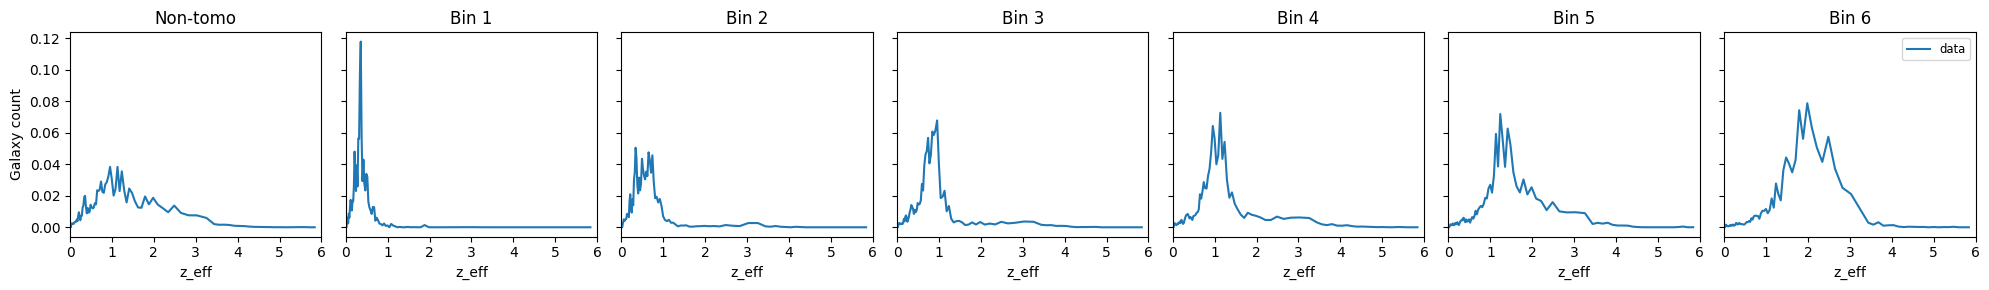

In [78]:
nz_RR2 = np.load('/global/cfs/cdirs/m5099/RR2/Reg2_SHE_tombins_unitweights_nz_SOMbin_C2020z_rebinned.npy',allow_pickle=True).item()

# -------------------------------------------------------
nz_shifted, shells, steps, zeff_glass, ngal_glass = apply_nz_shifts_and_build_shells(
    z_rebinned=nz_RR2['z_rebinned'],
    nz_all=nz_RR2['nz_rebinned'],
    dz_values=sims_parameters["dz"],
    shells_info=shells_info,
)

# Plot -----------------------------------------------------------------
fig, axes = plt.subplots(1, 7, figsize=(20, 3), sharey=True)
titles = ["Non-tomo"] + [f"Bin {i}" for i in range(1, 7)]
for i, ax in enumerate(axes):
    ax.plot(zeff_glass, ngal_glass[i], label="data")
    ax.set_xlim(0, 6)
    ax.set_title(titles[i])
    if i == 0: ax.set_ylabel("Galaxy count")
    ax.set_xlabel("z_eff")
axes[-1].legend(loc="upper right", fontsize="small")
plt.tight_layout(); plt.show()


# load density shells and compute shear field

In [32]:
particles = (cosmogridv11.utils_maps.load_v11_shells(path_simulations+'baryonified_shells_v11.h5','nobaryon_shells'))['particles']
density = particles / np.mean(particles, axis=1, keepdims=True) - 1

#add high redshift shells --------------
if len(shells)>len(density):
    missing_shells = []
    for i in range(len(density),len(shells)):
        missing_shells.append(shells[i])
    density_to_be_added = add_shells(cosmo_bundle['pars_camb'],nside_maps = nside_maps,missing_shells = missing_shells)
density = np.vstack([density,density_to_be_added])

# shear field ---------------------------
fields = compute_lensing_fields(density, shells, cosmo_bundle['pars_camb'], nside_maps, do_kappa=True, do_shear=True, do_IA=True)
fields['density'] = density

100.0% | [##########] | Progress: 69 / 69 | Time: 46.0s | ETA: --              

# Theory checks

/tmp/ipykernel_1321957/89455338.py:17: RuntimeWarning: divide by zero encountered in divide
  ax.plot(Cls[tomo, :ell_max]/(Cgg[tomo, tomo, :ell_max] * (pix**2)))


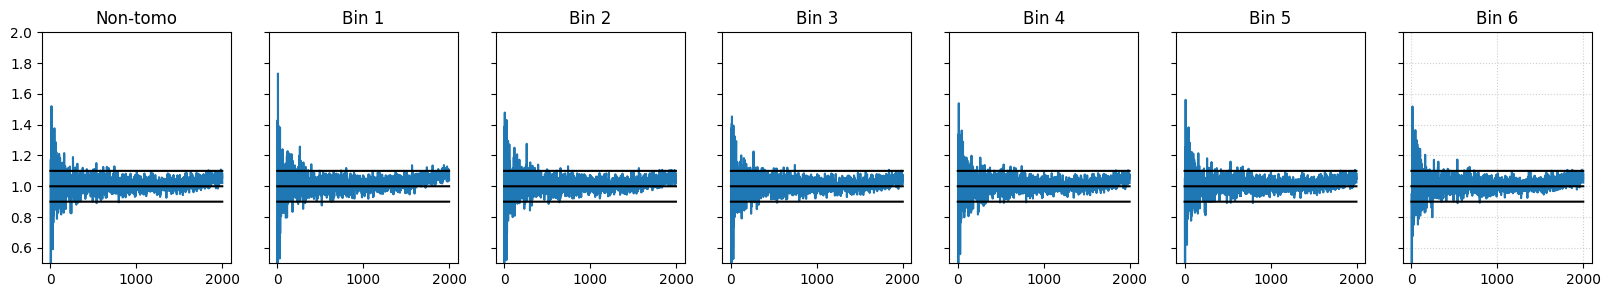

In [90]:
theory = LimberTheory(cosmo_bundle['pars_camb'], lmax=4000, nonlinear="euclidemu")  # "euclidemu" | "mead" | "halofit"
theory.set_Wshear(np.vstack([nz_RR2['z_rebinned'],nz_shifted]).T)
Cgg = theory.cl_gg(nonlinear=True)


kappa_tomo = integrate_field(ngal_glass, fields["kappa"])

Cls = np.array([(hp.anafast(kappa_tomo[tomo,:])) for tomo in range(len(ngal_glass))])



# choose a safe ℓ-range common to all arrays
ell_max = 2000
pix = hp.pixwin(nside_maps)[:ell_max]
ells = np.arange(ell_max)

mask_ell = ells >= 2  # avoid ℓ=0,1

fig, axes = plt.subplots(1, 7, figsize=(20, 3), sharey=True)
titles = ["Non-tomo"] + [f"Bin {i}" for i in range(1, 7)]
for tomo, ax in enumerate(axes):
    ax.plot(Cls[tomo, :ell_max]/(Cgg[tomo, tomo, :ell_max] * (pix**2)))
    ax.plot(np.ones(ell_max),color = 'black')
    ax.plot(0.9*np.ones(ell_max),color = 'black')
    ax.plot(1.1*np.ones(ell_max),color = 'black')
    ax.set_ylim([0.5,2])
    ax.set_title(titles[tomo])

ax.grid(True, which="both", ls=":", alpha=0.6)


# Make mocks/maps

In [ ]:
path_data_cats = '/global/cfs/cdirs/m5099/RR2/Euclid_cats.npy'
cats_Euclid  = np.load(path_data_cats,allow_pickle=True).item()
maps_Gower_WL, cat_Gower_WL = make_WL_sample(ngal_glass, zeff_glass, cosmo_bundle, sims_parameters, nside_maps, fields, cats_Euclid, SC_corrections = SC_corrections, do_catalog = False, include_SC = True)